## Operation


=== Essai 1 ===
Arêtes de l'arbre T : [(0, 1), (0, 2), (0, 3), (0, 4)]
Arêtes de coarbre : [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
x_f attribués :
  (0, 1) → 11178089
  (0, 2) → 1096887591
  (0, 3) → 1769536149
  (0, 4) → 627572227
Cycle fondamental de (1, 2) : {(0, 1), (0, 2)}
Cycle fondamental de (1, 3) : {(0, 1), (0, 3)}
Cycle fondamental de (1, 4) : {(0, 1), (0, 4)}
Cycle fondamental de (2, 3) : {(0, 2), (0, 3)}
Cycle fondamental de (2, 4) : {(0, 2), (0, 4)}
Cycle fondamental de (3, 4) : {(0, 3), (0, 4)}
A[0,1] ← somme des x_f pour f∈{(0, 1), (0, 2)}∩{(0, 1), (0, 3)} = [(0, 1)] → 11178089
A[0,2] ← somme des x_f pour f∈{(0, 1), (0, 2)}∩{(0, 1), (0, 4)} = [(0, 1)] → 11178089
A[0,3] ← somme des x_f pour f∈{(0, 1), (0, 2)}∩{(0, 2), (0, 3)} = [(0, 2)] → 1096887591
A[0,4] ← somme des x_f pour f∈{(0, 1), (0, 2)}∩{(0, 2), (0, 4)} = [(0, 2)] → 1096887591
A[0,5] ← somme des x_f pour f∈{(0, 1), (0, 2)}∩{(0, 3), (0, 4)} = [] → 0
A[1,2] ← somme des x_f pour f∈{(0, 1), (0, 3)}∩{(0, 1),

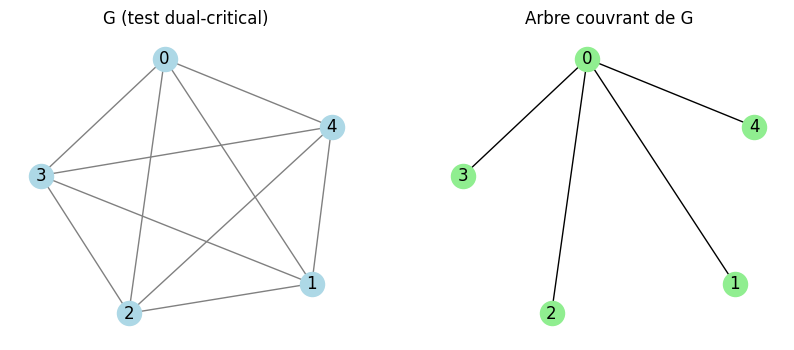

Le graphe est-il dual-critical ?  False


In [6]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Set

# =========================
# 1) Arbre couvrant
# =========================
def extract_spanning_tree(G: nx.Graph) -> nx.Graph:
    """Arbre couvrant par BFS (suppose G connexe)."""
    if len(G.nodes) == 0:
        return nx.Graph()
    if not nx.is_connected(G):
        raise ValueError("Le graphe doit être connexe pour ce test.")
    root = next(iter(G.nodes))
    T = nx.bfs_tree(G, root)
    return nx.Graph(T)

# =========================
# 2) Arithmétique exacte en GF(2^k)
# =========================
def _deg(p: int) -> int: return p.bit_length() - 1
def _gf2_add(a: int, b: int) -> int: return a ^ b
def _gf2_mul(a: int, b: int) -> int:
    res = 0
    while b:
        if b & 1: res ^= a
        a <<= 1; b >>= 1
    return res
def _gf2_mod(a: int, mod: int) -> int:
    m = _deg(mod)
    while a.bit_length() - 1 >= m:
        shift = (a.bit_length() - 1) - m
        a ^= mod << shift
    return a
def _gf2_mul_mod(a: int, b: int, mod: int) -> int: return _gf2_mod(_gf2_mul(a, b), mod)
def _gf2_gcd(a: int, b: int) -> int:
    while b: a, b = b, _gf2_mod(a, b)
    return a
def _gf2_is_irreducible(poly: int) -> bool:
    if poly < 3 or (poly & 1) == 0: return False
    m = _deg(poly)
    x = 0b10; x2i = x
    for _ in range(m): x2i = _gf2_mul_mod(x2i, x2i, poly)
    if _gf2_add(x2i, x) != 0: return False
    x2i = x
    for _ in range(1, m // 2 + 1):
        x2i = _gf2_mul_mod(x2i, x2i, poly)
        if _gf2_gcd(_gf2_add(x2i, x), poly) != 1: return False
    return True
def _random_irreducible(deg: int) -> int:
    while True:
        poly = (1 << deg) | 1
        mid = random.getrandbits(deg - 1)
        poly |= (mid << 1)
        if _gf2_is_irreducible(poly): return poly

class GF2k:
    __slots__ = ("mod",)
    def __init__(self, mod: int): self.mod = mod
    def add(self, a, b): return a ^ b
    def mul(self, a, b): return _gf2_mul_mod(a, b, self.mod)
    def inv(self, a):
        if a == 0: raise ZeroDivisionError("inverse de 0")
        u, v = a, self.mod; g1, g2 = 1, 0
        while u != 1:
            j = _deg(u) - _deg(v)
            if j < 0: u, v, g1, g2, j = v, u, g2, g1, -j
            u ^= v << j; g1 ^= g2 << j
        return _gf2_mod(g1, self.mod)
    def zero(self): return 0
    def one(self): return 1

def det_gf2k(A: List[List[int]], F: GF2k) -> int:
    n = len(A); M = [row[:] for row in A]; det = F.one()
    for c in range(n):
        piv = None
        for r in range(c, n):
            if M[r][c] != 0: piv = r; break
        if piv is None: return F.zero()
        if piv != c: M[c], M[piv] = M[piv], M[c]
        pv = M[c][c]; det = F.mul(det, pv); inv_pv = F.inv(pv)
        for j in range(c, n): M[c][j] = F.mul(M[c][j], inv_pv)
        for r in range(c+1, n):
            if M[r][c] != 0:
                fac = M[r][c]
                for j in range(c, n):
                    M[r][j] = F.add(M[r][j], F.mul(fac, M[c][j]))
    return det

# =========================
# 3) Outils cycles fondamentaux
# =========================
def _fundamental_cycle_tree_edges(T: nx.Graph, e: Tuple[int, int]) -> Set[Tuple[int, int]]:
    u, v = e
    path = nx.shortest_path(T, u, v)
    return {tuple(sorted((path[i], path[i+1]))) for i in range(len(path)-1)}

# =========================
# 4) Test randomisé de dual-criticalité
# =========================
def randomized_dual_criticality_test(G: nx.Graph, trials: int = 10) -> bool:
    """Test randomisé de dual-criticalité (Szegedy–Szegedy)."""
    T = extract_spanning_tree(G)
    tree_edges = {tuple(sorted(e)) for e in T.edges()}
    cotree_edges = [tuple(sorted(e)) for e in G.edges() if tuple(sorted(e)) not in tree_edges]
    n = len(cotree_edges)
    if n == 0:
        print("Pas d'arêtes de coarbre : matrice vide."); return False

    T_sets = [_fundamental_cycle_tree_edges(T, e) for e in cotree_edges]
    field_degree = 31; F = GF2k(_random_irreducible(field_degree))
    tree_edge_list = sorted(list(tree_edges))

    def draw_x(): 
        val = 0
        while val == 0: val = random.getrandbits(field_degree)
        return val

    for trial in range(1, trials+1):
        print(f"\n=== Essai {trial} ===")
        x: Dict[Tuple[int,int],int] = {f: draw_x() for f in tree_edge_list}

        print("Arêtes de l'arbre T :", tree_edge_list)
        print("Arêtes de coarbre :", cotree_edges)
        print("x_f attribués :")
        for f, val in x.items(): print(f"  {f} → {val}")

        for idx, e in enumerate(cotree_edges):
            print(f"Cycle fondamental de {e} : {T_sets[idx]}")

        # Matrice A
        A = [[F.zero() for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(i+1, n):
                s = F.zero(); contributors = []
                for f in T_sets[i]:
                    if f in T_sets[j]:
                        s = F.add(s, x[f]); contributors.append(f)
                A[i][j] = s; A[j][i] = s
                print(f"A[{i},{j}] ← somme des x_f pour f∈{T_sets[i]}∩{T_sets[j]} = {contributors} → {s}")

        print("\nMatrice A :")
        for row in A: print(row)

        detA = det_gf2k(A, F)
        print(f"Det(A) = {detA}")
        if detA != 0: 
            print("⇒ Graphe probablement dual-critical (det ≠ 0).")
            return True
    print("⇒ Graphe probablement non dual-critical (tous det = 0).")
    return False

# =========================
# 5) Visualisation
# =========================
def visualize_graph(G: nx.Graph, trials=10):
    """
    Lance le test et affiche le graphe et un arbre couvrant.
    """
    is_dual = randomized_dual_criticality_test(G, trials=trials)
    T = extract_spanning_tree(G)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 4))

    # Graphe G
    plt.subplot(121)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
    plt.title("G (test dual-critical)")

    # Arbre couvrant
    plt.subplot(122)
    nx.draw(T, pos, with_labels=True, node_color="lightgreen", edge_color="black")
    plt.title("Arbre couvrant de G")

    plt.show()

    return is_dual

# =========================
# Exemple d'utilisation
# =========================
if __name__ == "__main__":
    G = nx.complete_graph(5)
    result = visualize_graph(G, trials=5)
    print("Le graphe est-il dual-critical ? ", result)


## Spanning trees

Unique spanning tree classes (up to isomorphism): 6


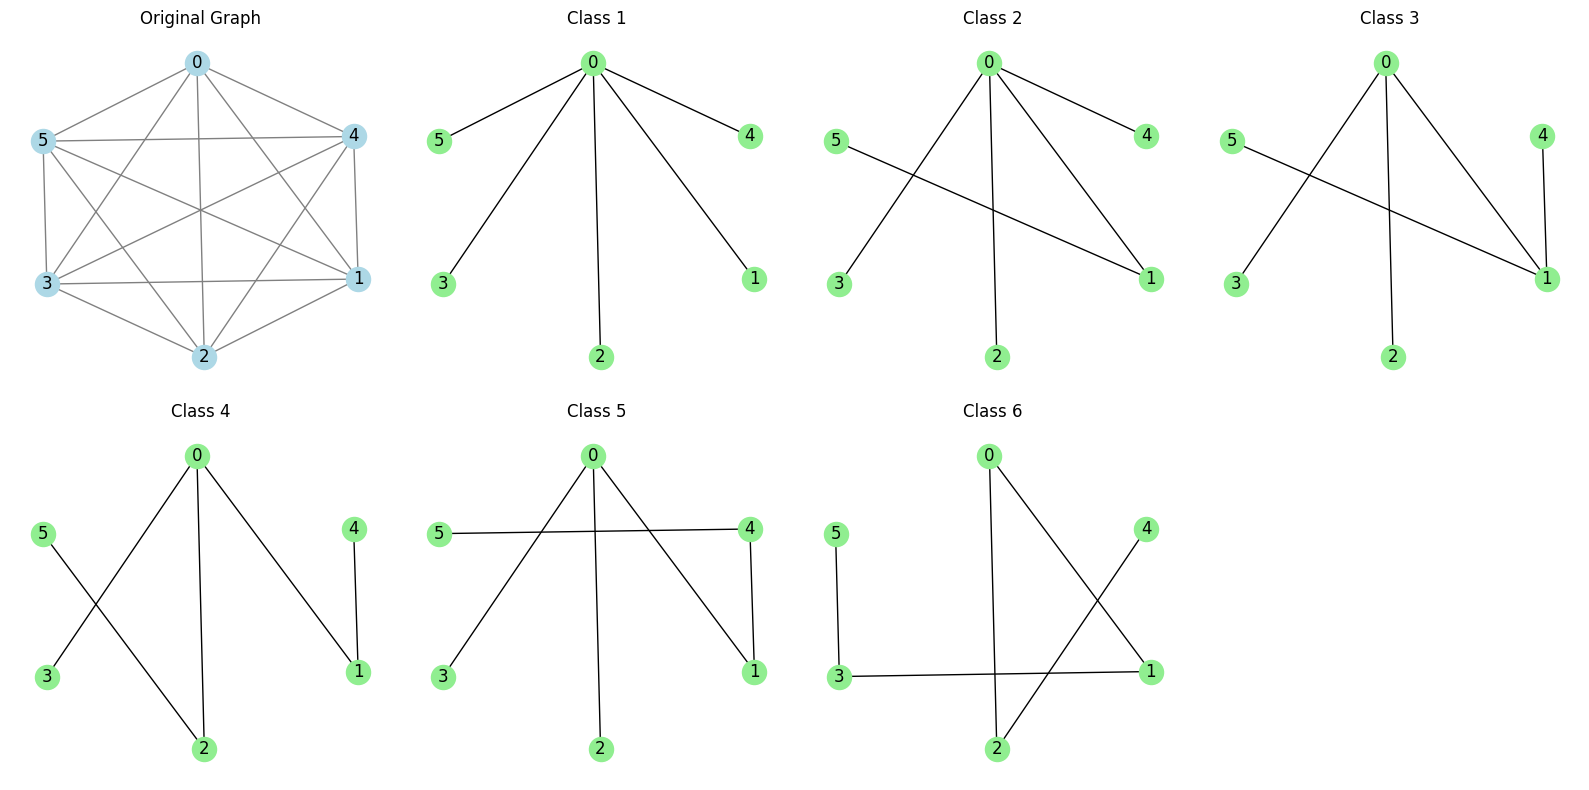

In [7]:
# =========================
# Visualization + print construction steps + matrices symboliques + det(A) + subdeterminants
# with random symmetric replacement for A_aug
# =========================
import networkx as nx
import matplotlib.pyplot as plt
from typing import List

def extract_unique_spanning_trees(G: nx.Graph) -> List[nx.Graph]:
    """
    Extract representatives of spanning trees of G,
    keeping only one graph per isomorphism class.
    Returns a list of networkx.Graph objects.
    """
    nodes = list(G.nodes())
    n = len(nodes)
    if n == 0:
        return []

    edges = list(G.edges())
    trees = []

    parent = {v: v for v in nodes}

    def find(x):
        while parent[x] != x:
            x = parent[x]
        return x

    def union(u, v):
        ru, rv = find(u), find(v)
        if ru == rv:
            return False, None
        parent[rv] = ru
        return True, rv

    def undo(rv):
        if rv is not None:
            parent[rv] = rv

    chosen = []

    def dfs(i, count):
        if count == n - 1:
            T = nx.Graph()
            T.add_nodes_from(nodes)
            T.add_edges_from(chosen)

            # keep only if it's a new isomorphism class
            if not any(nx.is_isomorphic(T, U) for U in trees):
                trees.append(T)
            return
        if i >= len(edges):
            return

        u, v = edges[i]

        merged, rv = union(u, v)
        if merged:
            chosen.append((u, v))
            dfs(i + 1, count + 1)
            chosen.pop()
            undo(rv)

        dfs(i + 1, count)

    dfs(0, 0)
    return trees

# Example usage
if __name__ == "__main__":
    G = nx.complete_graph(6)
    unique_trees = extract_unique_spanning_trees(G)
    print(f"Unique spanning tree classes (up to isomorphism): {len(unique_trees)}")

    pos = nx.spring_layout(G, seed=42)

    cols = min(4, len(unique_trees) + 1)
    rows = (len(unique_trees) + 1 + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))

    # Original graph
    plt.subplot(rows, cols, 1)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
    plt.title("Original Graph")

    # Representatives of each class
    for i, T in enumerate(unique_trees, start=2):
        plt.subplot(rows, cols, i)
        nx.draw(T, pos, with_labels=True, node_color="lightgreen", edge_color="black")
        plt.title(f"Class {i-1}")

    plt.tight_layout()
    plt.show()



## Algorithm

In [8]:
def visualize_classes_with_sigma_and_dets_verbose_xor_randomized(G: nx.Graph, field_degree: int = 31):
    reps = extract_unique_spanning_trees(G)
    pos = nx.spring_layout(G, seed=42)
    k = len(reps)

    print(f"Nombre de représentants (classes d'isomorphie) : {k}\n", flush=True)

    for idx, T in enumerate(reps):
        print(f"\n--- Classe {idx+1}/{k} ---")

        # Draw graphs
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
        plt.title("G")
        plt.subplot(122)
        nx.draw(T, pos, with_labels=True, node_color="lightgreen", edge_color="black")
        plt.title(f"Arbre couvrant (Rep {idx+1})")
        plt.tight_layout()
        plt.draw()
        plt.pause(0.5)
        plt.close()

        # Tree and cotree edges
        tree_edges = {tuple(sorted(e)) for e in T.edges()}
        cotree_edges = [tuple(sorted(e)) for e in G.edges() if tuple(sorted(e)) not in tree_edges]
        n = len(cotree_edges)
        if n == 0:
            print("  Pas d'arêtes de coarbre pour cet arbre (matrice vide).", flush=True)
            continue

        # Fundamental cycles
        T_sets = [_fundamental_cycle_tree_edges(T, e) for e in cotree_edges]
        for i, cycle in enumerate(T_sets):
            print(f"Cycle fondamental pour arête du coarbre {cotree_edges[i]} : {cycle}", flush=True)

        tree_edge_list = sorted(list(tree_edges))
        F = GF2k(_random_irreducible(field_degree))

        # Random x_f
        x: dict = {}
        for f in tree_edge_list:
            v = 0
            while v == 0: v = random.getrandbits(field_degree)
            x[f] = v

        # Symbolic names
        x_names = {f: f"x{i+1}" for i, f in enumerate(tree_edge_list)}

        # A original (symbolic)
        A = [[F.zero() for _ in range(n)] for _ in range(n)]
        A_sym = [["0" for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(i+1, n):
                s = F.zero()
                s_sym_list = []
                intersect_edges = T_sets[i] & T_sets[j]
                for f in intersect_edges:
                    s = F.add(s, x[f])
                    s_sym_list.append(x_names[f])
                A[i][j] = s
                A[j][i] = s
                A_sym[i][j] = " + ".join(s_sym_list) if s_sym_list else "0"
                A_sym[j][i] = A_sym[i][j]

        detA = det_gf2k(A, F)
        print(f"\nDéterminant de la matrice A originale : {detA}", flush=True)

        # Sigma
        Sigma_set = set()
        for cycle in T_sets:
            Sigma_set ^= cycle

        # A_aug
        A_aug = [row + [F.zero()] for row in A]
        A_aug.append([F.zero() for _ in range(n+1)])
        A_aug_sym = [row + ["0"] for row in A_sym]
        A_aug_sym.append(["0" for _ in range(n+1)])

        for j, cycle in enumerate(T_sets):
            Sigma_modified = (Sigma_set & cycle) ^ cycle
            s_num = F.zero()
            s_sym_list = []
            for f in Sigma_modified:
                s_num = F.add(s_num, x[f])
                s_sym_list.append(x_names[f])
            A_aug[n][j] = s_num
            A_aug[j][n] = s_num
            A_aug_sym[n][j] = " + ".join(s_sym_list) if s_sym_list else "0"
            A_aug_sym[j][n] = A_aug_sym[n][j]

        print("\nMatrice augmentée A' avec Σ modifié (symbolique) :", flush=True)
        for row in A_aug_sym: print(row)

        # =========================
        # Create new random symmetric matrix for det(A_aug) and subdeterminants
        # =========================
        y_matrix = [[F.zero() for _ in range(n+1)] for _ in range(n+1)]
        for i in range(n+1):
            for j in range(i+1, n+1):
                if A_aug[i][j] != F.zero():
                    val = random.getrandbits(field_degree)
                    y_matrix[i][j] = val
                    y_matrix[j][i] = val

        detA_aug_random = det_gf2k(y_matrix, F)
        print(f"\nDéterminant de A' avec nouvelles variables aléatoires : {detA_aug_random}", flush=True)

        print("\nSous-déterminants en retirant chaque arête du coarbre avec variables aléatoires :", flush=True)
        for remove_idx, e in enumerate(cotree_edges):
            submat_y = [[y_matrix[i][j] for j in range(n+1) if j != remove_idx]
                        for i in range(n+1) if i != remove_idx]
            det_sub_y = det_gf2k(submat_y, F)
            print(f"  Déterminant en retirant l'arête {e}: {det_sub_y}", flush=True)

        print("\n--- Fin de la classe {}/{} ---\n".format(idx+1, k), flush=True)

Nombre de représentants (classes d'isomorphie) : 6


--- Classe 1/6 ---


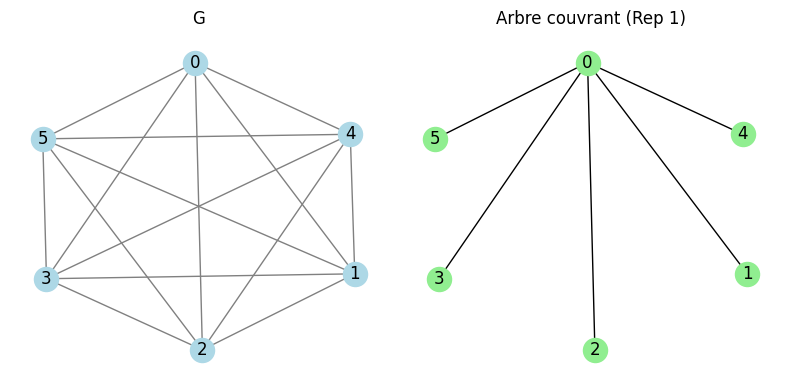

Cycle fondamental pour arête du coarbre (1, 2) : {(0, 1), (0, 2)}
Cycle fondamental pour arête du coarbre (1, 3) : {(0, 1), (0, 3)}
Cycle fondamental pour arête du coarbre (1, 4) : {(0, 1), (0, 4)}
Cycle fondamental pour arête du coarbre (1, 5) : {(0, 1), (0, 5)}
Cycle fondamental pour arête du coarbre (2, 3) : {(0, 2), (0, 3)}
Cycle fondamental pour arête du coarbre (2, 4) : {(0, 2), (0, 4)}
Cycle fondamental pour arête du coarbre (2, 5) : {(0, 2), (0, 5)}
Cycle fondamental pour arête du coarbre (3, 4) : {(0, 3), (0, 4)}
Cycle fondamental pour arête du coarbre (3, 5) : {(0, 3), (0, 5)}
Cycle fondamental pour arête du coarbre (4, 5) : {(0, 4), (0, 5)}

Déterminant de la matrice A originale : 0

Matrice augmentée A' avec Σ modifié (symbolique) :
['0', 'x1', 'x1', 'x1', 'x2', 'x2', 'x2', '0', '0', '0', 'x1 + x2']
['x1', '0', 'x1', 'x1', 'x3', '0', '0', 'x3', 'x3', '0', 'x1 + x3']
['x1', 'x1', '0', 'x1', '0', 'x4', '0', 'x4', '0', 'x4', 'x1 + x4']
['x1', 'x1', 'x1', '0', '0', '0', 'x5', '

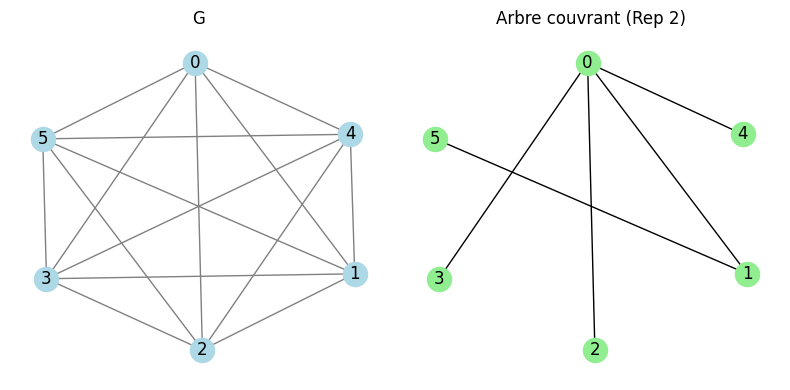

Cycle fondamental pour arête du coarbre (0, 5) : {(0, 1), (1, 5)}
Cycle fondamental pour arête du coarbre (1, 2) : {(0, 1), (0, 2)}
Cycle fondamental pour arête du coarbre (1, 3) : {(0, 1), (0, 3)}
Cycle fondamental pour arête du coarbre (1, 4) : {(0, 1), (0, 4)}
Cycle fondamental pour arête du coarbre (2, 3) : {(0, 2), (0, 3)}
Cycle fondamental pour arête du coarbre (2, 4) : {(0, 2), (0, 4)}
Cycle fondamental pour arête du coarbre (2, 5) : {(0, 1), (0, 2), (1, 5)}
Cycle fondamental pour arête du coarbre (3, 4) : {(0, 3), (0, 4)}
Cycle fondamental pour arête du coarbre (3, 5) : {(0, 1), (0, 3), (1, 5)}
Cycle fondamental pour arête du coarbre (4, 5) : {(0, 1), (0, 4), (1, 5)}

Déterminant de la matrice A originale : 0

Matrice augmentée A' avec Σ modifié (symbolique) :
['0', 'x1', 'x1', 'x1', '0', '0', 'x1 + x5', '0', 'x1 + x5', 'x1 + x5', 'x5']
['x1', '0', 'x1', 'x1', 'x2', 'x2', 'x1 + x2', '0', 'x1', 'x1', 'x2']
['x1', 'x1', '0', 'x1', 'x3', '0', 'x1', 'x3', 'x1 + x3', 'x1', 'x3']
['x

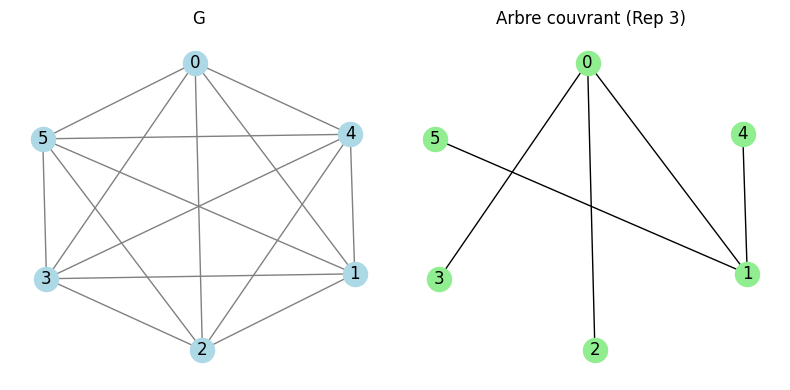

Cycle fondamental pour arête du coarbre (0, 4) : {(0, 1), (1, 4)}
Cycle fondamental pour arête du coarbre (0, 5) : {(0, 1), (1, 5)}
Cycle fondamental pour arête du coarbre (1, 2) : {(0, 1), (0, 2)}
Cycle fondamental pour arête du coarbre (1, 3) : {(0, 1), (0, 3)}
Cycle fondamental pour arête du coarbre (2, 3) : {(0, 2), (0, 3)}
Cycle fondamental pour arête du coarbre (2, 4) : {(0, 1), (0, 2), (1, 4)}
Cycle fondamental pour arête du coarbre (2, 5) : {(0, 1), (0, 2), (1, 5)}
Cycle fondamental pour arête du coarbre (3, 4) : {(0, 1), (0, 3), (1, 4)}
Cycle fondamental pour arête du coarbre (3, 5) : {(0, 1), (0, 3), (1, 5)}
Cycle fondamental pour arête du coarbre (4, 5) : {(1, 4), (1, 5)}

Déterminant de la matrice A originale : 0

Matrice augmentée A' avec Σ modifié (symbolique) :
['0', 'x1', 'x1', 'x1', '0', 'x1 + x4', 'x1', 'x1 + x4', 'x1', 'x4', 'x1 + x4']
['x1', '0', 'x1', 'x1', '0', 'x1', 'x1 + x5', 'x1', 'x1 + x5', 'x5', 'x1 + x5']
['x1', 'x1', '0', 'x1', 'x2', 'x1 + x2', 'x1 + x2', '

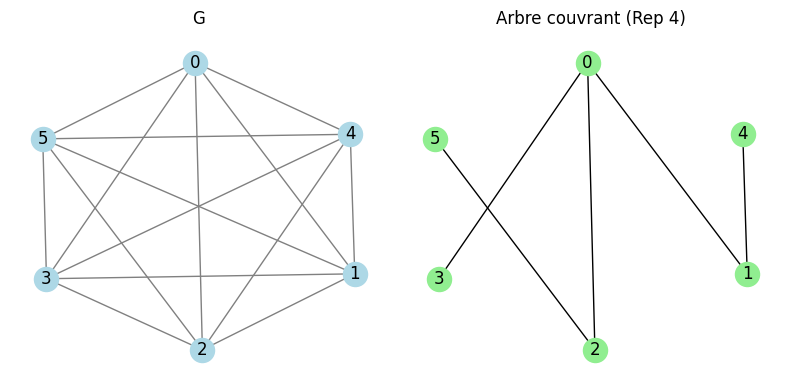

Cycle fondamental pour arête du coarbre (0, 4) : {(0, 1), (1, 4)}
Cycle fondamental pour arête du coarbre (0, 5) : {(0, 2), (2, 5)}
Cycle fondamental pour arête du coarbre (1, 2) : {(0, 1), (0, 2)}
Cycle fondamental pour arête du coarbre (1, 3) : {(0, 1), (0, 3)}
Cycle fondamental pour arête du coarbre (1, 5) : {(0, 1), (0, 2), (2, 5)}
Cycle fondamental pour arête du coarbre (2, 3) : {(0, 2), (0, 3)}
Cycle fondamental pour arête du coarbre (2, 4) : {(0, 1), (0, 2), (1, 4)}
Cycle fondamental pour arête du coarbre (3, 4) : {(0, 1), (0, 3), (1, 4)}
Cycle fondamental pour arête du coarbre (3, 5) : {(0, 2), (0, 3), (2, 5)}
Cycle fondamental pour arête du coarbre (4, 5) : {(0, 1), (0, 2), (2, 5), (1, 4)}

Déterminant de la matrice A originale : 0

Matrice augmentée A' avec Σ modifié (symbolique) :
['0', '0', 'x1', 'x1', 'x1', '0', 'x1 + x4', 'x1 + x4', '0', 'x1 + x4', 'x4']
['0', '0', 'x2', '0', 'x2 + x5', 'x2', 'x2', '0', 'x2 + x5', 'x2 + x5', 'x5']
['x1', 'x2', '0', 'x1', 'x1 + x2', 'x2', 

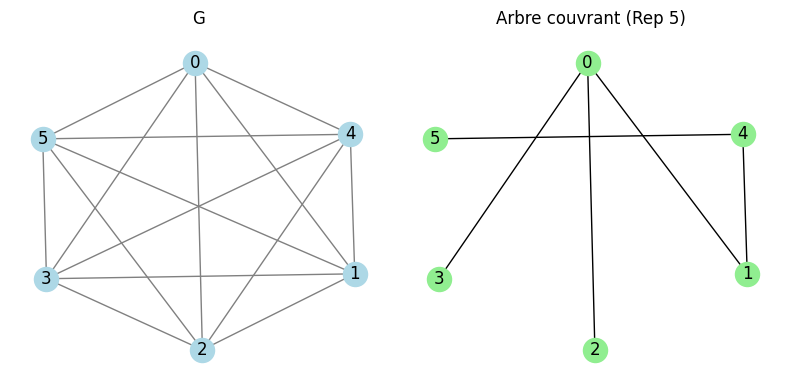

Cycle fondamental pour arête du coarbre (0, 4) : {(0, 1), (1, 4)}
Cycle fondamental pour arête du coarbre (0, 5) : {(0, 1), (4, 5), (1, 4)}
Cycle fondamental pour arête du coarbre (1, 2) : {(0, 1), (0, 2)}
Cycle fondamental pour arête du coarbre (1, 3) : {(0, 1), (0, 3)}
Cycle fondamental pour arête du coarbre (1, 5) : {(4, 5), (1, 4)}
Cycle fondamental pour arête du coarbre (2, 3) : {(0, 2), (0, 3)}
Cycle fondamental pour arête du coarbre (2, 4) : {(0, 1), (0, 2), (1, 4)}
Cycle fondamental pour arête du coarbre (2, 5) : {(0, 1), (0, 2), (4, 5), (1, 4)}
Cycle fondamental pour arête du coarbre (3, 4) : {(0, 1), (0, 3), (1, 4)}
Cycle fondamental pour arête du coarbre (3, 5) : {(0, 1), (4, 5), (0, 3), (1, 4)}

Déterminant de la matrice A originale : 0

Matrice augmentée A' avec Σ modifié (symbolique) :
['0', 'x1 + x4', 'x1', 'x1', 'x4', '0', 'x1 + x4', 'x1 + x4', 'x1 + x4', 'x1 + x4', 'x1']
['x1 + x4', '0', 'x1', 'x1', 'x5 + x4', '0', 'x1 + x4', 'x1 + x5 + x4', 'x1 + x4', 'x1 + x5 + x4', 

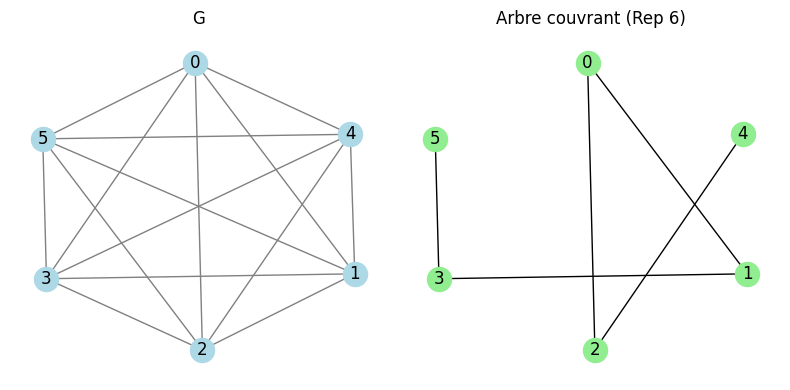

Cycle fondamental pour arête du coarbre (0, 3) : {(0, 1), (1, 3)}
Cycle fondamental pour arête du coarbre (0, 4) : {(0, 2), (2, 4)}
Cycle fondamental pour arête du coarbre (0, 5) : {(0, 1), (1, 3), (3, 5)}
Cycle fondamental pour arête du coarbre (1, 2) : {(0, 1), (0, 2)}
Cycle fondamental pour arête du coarbre (1, 4) : {(0, 1), (0, 2), (2, 4)}
Cycle fondamental pour arête du coarbre (1, 5) : {(1, 3), (3, 5)}
Cycle fondamental pour arête du coarbre (2, 3) : {(0, 1), (0, 2), (1, 3)}
Cycle fondamental pour arête du coarbre (2, 5) : {(0, 1), (0, 2), (1, 3), (3, 5)}
Cycle fondamental pour arête du coarbre (3, 4) : {(0, 1), (0, 2), (1, 3), (2, 4)}
Cycle fondamental pour arête du coarbre (4, 5) : {(0, 1), (2, 4), (0, 2), (1, 3), (3, 5)}

Déterminant de la matrice A originale : 0

Matrice augmentée A' avec Σ modifié (symbolique) :
['0', '0', 'x1 + x3', 'x1', 'x1', 'x3', 'x1 + x3', 'x1 + x3', 'x1 + x3', 'x1 + x3', 'x1']
['0', '0', '0', 'x2', 'x2 + x4', '0', 'x2', 'x2', 'x2 + x4', 'x2 + x4', 'x4

In [9]:
# Example: complete graph with 4 vertices
G = nx.complete_graph(6)

# Call your function
visualize_classes_with_sigma_and_dets_verbose_xor_randomized(G, field_degree=31)
